In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from collections import Counter
import pickle as pkl
import random
import pdb
import string
import csv
import io

# Load in data

In [90]:
# punctuations = string.punctuation

In [91]:
def dataset_builder(path):
    
    sent1_store = []
    sent2_store = []
    label_store = []

    with open(path) as tsvfile:
        reader = csv.DictReader(tsvfile, dialect='excel-tab')
        for row in reader: 
#             sent = [token.lower() for token in row["sentence1"].split() if (token not in punctuations) and (token not in stop_words.ENGLISH_STOP_WORDS)]
#             sent1 = [token.lower() for token in row["sentence1"].split() if token not in punctuations]
#             sent2 = [token.lower() for token in row["sentence2"].split() if token not in punctuations]
            sent1 = [token.lower() for token in row["sentence1"].split()]
            sent2 = [token.lower() for token in row["sentence2"].split()]
            sent1_store.append(sent1)
            sent2_store.append(sent2)
            label_store.append(row["label"])     
    return sent1_store, sent2_store, label_store

In [92]:
train_sent1, train_sent2, train_label = dataset_builder("snli_train.tsv")
val_sent1, val_sent2, val_label = dataset_builder("snli_val.tsv")

In [93]:
test_set = pd.read_csv("mnli_val.tsv", sep="\t")
test_dict = {} 
# a nested dict, e.g. test_dict['fiction']['sent1'], test_dict['fiction']['sent2'], test_dict['fiction']['label']
genre_lst = pd.unique(test_set["genre"])
# array(['fiction', 'telephone', 'slate', 'government', 'travel']

for genre in genre_lst:
    test_dict[genre]={} 
    test_dict[genre]['sent1']=[]
    test_dict[genre]['sent2']=[]
    test_dict[genre]['label']=[]
    for row in test_set[test_set["genre"]==genre]['sentence1']:
        test_dict[genre]['sent1'].append([token.lower() for token in row.split()])
    for row in test_set[test_set["genre"]==genre]['sentence2']:
        test_dict[genre]['sent2'].append([token.lower() for token in row.split()])
    for row in test_set[test_set["genre"]==genre]['label']:
        test_dict[genre]['label'].append(row)

In [94]:
# double check
print ("Train dataset size is {}".format(len(train_label)))
print ("\nVal dataset size is {}".format(len(val_label)))
print ("")
for genre in genre_lst:
    print ("Test dataset size of genre {} is {}".format(genre, len(test_dict[genre]['label'])))

Train dataset size is 100000

Val dataset size is 1000

Test dataset size of genre fiction is 995
Test dataset size of genre telephone is 1005
Test dataset size of genre slate is 1002
Test dataset size of genre government is 1016
Test dataset size of genre travel is 982


In [95]:
# label list encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_label)
train_label = le.transform(train_label)
val_label = le.transform(val_label)
for genre in genre_lst:
    test_dict[genre]['label'] = le.transform(test_dict[genre]['label'])

# Build Vocabulary by pre-trained fastText

In [8]:
words_to_load = 50000

f = io.open('wiki-news-300d-1M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')

ft_weights = np.zeros((words_to_load, 300))
# loaded_embeddings_ft.shape = (50000, 300)
# pre-trained weights

words2idx = {} # e.g. ('the': 2)
idx2words = {} # e.g. (2: 'the')
all_words = [] # e.g. top 50k words in vocab

for i, line in enumerate(f):
    # line is str
    if i >= words_to_load: 
        break
    s = line.split() # len(s)=301, s[0] is the word, the rest is its pre-trained vector
    ft_weights[i, :] = np.asarray(s[1:])
    words2idx[s[0]] = i
    idx2words[i] = s[0]
    all_words.append(s[0])

In [9]:
PAD_IDX = 0
UNK_IDX = 1  

In [10]:
# vectorize the sequence
def words_indexer(data):
    indices_data = []
    for sent in data:
        index_list = [words2idx[words] if words in words2idx else UNK_IDX for words in sent]  
        indices_data.append(index_list)  
    return indices_data

In [11]:
# train
train_sent1_indices = words_indexer(train_sent1)
train_sent2_indices = words_indexer(train_sent2)

# val
val_sent1_indices = words_indexer(val_sent1)
val_sent2_indices = words_indexer(val_sent2)

# test
test_indices_dict = {}
for genre in genre_lst:
    test_indices_dict[genre] = {}
    test_indices_dict[genre]['sent1'] = words_indexer(test_dict[genre]['sent1'])
    test_indices_dict[genre]['sent2'] = words_indexer(test_dict[genre]['sent2'])

# Input Pipeline for PyTorch

In [12]:
max_sent1_length = 25
max_sent2_length = 15

class SentDataset(Dataset):
  
    def __init__(self, sent1_list, sent2_list, target_list):
    
        self.sent1_list = sent1_list
        self.sent2_list = sent2_list
        self.target_list = target_list
        assert (len(self.sent1_list) == len(self.target_list)) and (len(self.sent2_list) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        sent1_idx = self.sent1_list[key][:max_sent1_length]
        sent2_idx = self.sent2_list[key][:max_sent2_length]
        label = self.target_list[key]
        
        return [[sent1_idx, sent2_idx], [len(sent1_idx), len(sent2_idx)], label]

In [13]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    sent1_list = []
    sent2_list = []
    label_list = []
    len1_list = []
    len2_list = []

    for datum in batch:
        label_list.append(datum[2])
        len1_list.append(datum[1][0])
        len2_list.append(datum[1][1])
    
    # padding
    for datum in batch:
        
        padded_sent1 = np.pad(np.array(datum[0][0]),
                              pad_width=((0,max_sent1_length-datum[1][0])),
                              mode="constant", constant_values=0)
        sent1_list.append(padded_sent1)
        
        padded_sent2 = np.pad(np.array(datum[0][1]),
                              pad_width=((0,max_sent2_length-datum[1][1])),
                              mode="constant", constant_values=0)
        sent2_list.append(padded_sent2)
    
#     return [torch.from_numpy(np.array(sent1_list)), torch.from_numpy(np.array(sent2_list)), 
#             torch.LongTensor(len1_list), torch.LongTensor(len2_list), 
#             torch.LongTensor(label_list)]
      
      #run on GPU
    return [torch.from_numpy(np.array(sent1_list)).cuda(), torch.from_numpy(np.array(sent2_list)).cuda(), 
            torch.LongTensor(len1_list).cuda(), torch.LongTensor(len2_list).cuda(), 
            torch.LongTensor(label_list).cuda()]

In [14]:
batch_size = 32

In [15]:
# create datasets and construct dataloader
sent_train = SentDataset(train_sent1_indices, train_sent2_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=sent_train, 
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

sent_val = SentDataset(val_sent1_indices, val_sent2_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=sent_val, 
                                         batch_size=batch_size,
                                         collate_fn=vocab_collate_func,
                                         shuffle=False)

# test
test_loader_dict = {}
for genre in genre_lst:
    test_loader_dict[genre] = torch.utils.data.DataLoader(dataset=SentDataset(test_indices_dict[genre]['sent1'], test_indices_dict[genre]['sent2'],  test_dict[genre]['label']), 
                                         batch_size=batch_size,
                                         collate_fn=vocab_collate_func,
                                         shuffle=False)

# Define Gated Recurrent Network

In [16]:
class GRU(nn.Module):
#     def __init__(self, emb_size, hidden_size, num_layers, num_classes, linear_dim, drop_out):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, linear_dim):
        
        # GRU Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN, the units in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # linear_dim: the dimension of fully connected layer
        
        super(GRU, self).__init__()
        
        # self.num_layers, self.hidden_size, self.drop_out = num_layers, hidden_size, drop_out
        self.num_layers, self.hidden_size = num_layers, hidden_size
        # use fasttext pre-trained embedding
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(ft_weights), freeze=True)
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(hidden_size*2, linear_dim) # *2 since we concat two representations
        self.linear2 = nn.Linear(linear_dim, num_classes)
        
        

    def init_hidden(self, batch_size):
        # Function initializes the activation of gated recurrent network at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        
        #hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        
        # GPU
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).cuda()
        
        return hidden

    
    def forward(self, sent1, sent2, len1, len2):

        batch1_size, seq1_len = sent1.size()
        batch2_size, seq2_len = sent2.size()
    
        # reset hidden state
        self.hidden = self.init_hidden(batch1_size)
        
        embed_sent1 = self.embedding(sent1).float()
        embed_sent2 = self.embedding(sent2).float()
        
        # sort the seqs in des order
        _, idx1_sort = torch.sort(len1, dim=0, descending=True)
        _, idx1_unsort = torch.sort(idx1_sort, dim=0)
        embed_sent1 = embed_sent1.index_select(0, idx1_sort)
        len1 = list(len1[idx1_sort])

        _, idx2_sort = torch.sort(len2, dim=0, descending=True)
        _, idx2_unsort = torch.sort(idx2_sort, dim=0)
        embed_sent2 = embed_sent2.index_select(0, idx2_sort)
        len2 = list(len2[idx2_sort])
        
        # transform pytorch tensor to padded sequence, pack padded sequence
        embed_sent1 = torch.nn.utils.rnn.pack_padded_sequence(embed_sent1, np.array(len1), batch_first=True)
        embed_sent2 = torch.nn.utils.rnn.pack_padded_sequence(embed_sent2, np.array(len2), batch_first=True)
        
        # fprop through GRN and get the dense representation 
        # gru_out shape -> em_size*hidden_size*num_layers
        _, sent1_hidden = self.gru(embed_sent1, self.hidden)
        _, sent2_hidden = self.gru(embed_sent2, self.hidden)
        
        # sum up to compress the hidden representation
        sent1_hidden = torch.sum(sent1_hidden, dim=0)
        sent2_hidden = torch.sum(sent2_hidden, dim=0)
        
        # unsort to get the matching order
        sent1_hidden = sent1_hidden.index_select(0,idx1_unsort)
        sent2_hidden = sent2_hidden.index_select(0,idx2_unsort)
        
        # concatenate two hidden representation 
        hidden_cat = torch.cat([sent1_hidden, sent2_hidden], dim=1)
        
        # feed to 2-layer fully connected
        gru_out = self.linear1(hidden_cat)
        # gru_out= F.dropout(gru_out, self.drop_out)
        gru_out = F.relu(gru_out)
        logits = self.linear2(gru_out)
        
        return  logits

# Training 

In [17]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sent1, sent2, len1, len2, labels in loader:
        sent1_batch, sent2_batch, len1_batch, len2_batch, label_batch = sent1, sent2, len1, len2, labels
        outputs = F.softmax(model(sent1_batch, sent2_batch, len1_batch, len2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [18]:
# hyperparameters
model = GRU(emb_size=300, hidden_size=600, num_layers=2, num_classes=3, linear_dim=100)
# model = GRU(emb_size=300, hidden_size=600, num_layers=2, num_classes=3, linear_dim=100, drop_out=0.5)
model.cuda()

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# Train the model
loss_store = []
train_acc_store = []
val_acc_store = []

for epoch in range(num_epochs):
    epoch_loss_lst =[]
    for i, (sent1, sent2, len1, len2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(sent1, sent2, len1, len2)
        loss = criterion(outputs, labels)
        epoch_loss_lst.append(loss)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 200 iterations
        if i > 0 and i % 200 == 0:
            train_acc = test_model(train_loader, model)
            train_acc_store.append(train_acc)
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_store.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
    loss_store.append(sum(epoch_loss_lst).cpu().detach().numpy())


Epoch: [1/10], Step: [201/3125], Training Acc: 44.467, Validation Acc: 44.3
Epoch: [1/10], Step: [401/3125], Training Acc: 49.713, Validation Acc: 49.5
Epoch: [1/10], Step: [601/3125], Training Acc: 53.042, Validation Acc: 51.8
Epoch: [1/10], Step: [801/3125], Training Acc: 55.077, Validation Acc: 53.1
Epoch: [1/10], Step: [1001/3125], Training Acc: 55.349, Validation Acc: 54.6
Epoch: [1/10], Step: [1201/3125], Training Acc: 56.631, Validation Acc: 54.7
Epoch: [1/10], Step: [1401/3125], Training Acc: 56.801, Validation Acc: 57.0
Epoch: [1/10], Step: [1601/3125], Training Acc: 58.199, Validation Acc: 59.1
Epoch: [1/10], Step: [1801/3125], Training Acc: 58.062, Validation Acc: 57.1
Epoch: [1/10], Step: [2001/3125], Training Acc: 59.003, Validation Acc: 58.8
Epoch: [1/10], Step: [2201/3125], Training Acc: 58.057, Validation Acc: 57.3
Epoch: [1/10], Step: [2401/3125], Training Acc: 59.821, Validation Acc: 59.2
Epoch: [1/10], Step: [2601/3125], Training Acc: 60.675, Validation Acc: 60.1
Epo

Epoch: [8/10], Step: [601/3125], Training Acc: 81.015, Validation Acc: 71.7
Epoch: [8/10], Step: [801/3125], Training Acc: 80.739, Validation Acc: 71.2
Epoch: [8/10], Step: [1001/3125], Training Acc: 81.911, Validation Acc: 72.5
Epoch: [8/10], Step: [1201/3125], Training Acc: 81.598, Validation Acc: 71.3
Epoch: [8/10], Step: [1401/3125], Training Acc: 81.995, Validation Acc: 69.8
Epoch: [8/10], Step: [1601/3125], Training Acc: 82.116, Validation Acc: 71.9
Epoch: [8/10], Step: [1801/3125], Training Acc: 82.542, Validation Acc: 71.0
Epoch: [8/10], Step: [2001/3125], Training Acc: 82.68, Validation Acc: 69.2
Epoch: [8/10], Step: [2201/3125], Training Acc: 82.576, Validation Acc: 70.1
Epoch: [8/10], Step: [2401/3125], Training Acc: 82.926, Validation Acc: 71.3
Epoch: [8/10], Step: [2601/3125], Training Acc: 82.788, Validation Acc: 72.3
Epoch: [8/10], Step: [2801/3125], Training Acc: 83.039, Validation Acc: 71.8
Epoch: [8/10], Step: [3001/3125], Training Acc: 82.754, Validation Acc: 69.6
Ep

In [70]:
# save the result for later plotting
acc_dict = {}
loss_dict = {}
loss_dict['training loss'] = loss_store
acc_dict['training accuracy'] = train_acc_store
acc_dict['validation accuracy'] = val_acc_store
acc_df = pd.DataFrame(acc_dict)
loss_df = pd.DataFrame(loss_dict)
acc_df.to_csv("./GRN/acc_h600_d5.csv")
loss_df.to_csv("./GRN/loss_h600_d5.csv")

# Hyperparameter Tuning

# 1. Hidden Size

In [114]:
val_acc_h100 = pd.read_csv("./GRN/acc_h100_d0.csv")['validation accuracy']
val_acc_h200 = pd.read_csv("./GRN/acc_h200_d0.csv")['validation accuracy']
val_acc_h400 = pd.read_csv("./GRN/acc_h400_d0.csv")['validation accuracy']
val_acc_h600 = pd.read_csv("./GRN/acc_h600_d0.csv")['validation accuracy']

In [119]:
max(val_acc_h600)

73.8

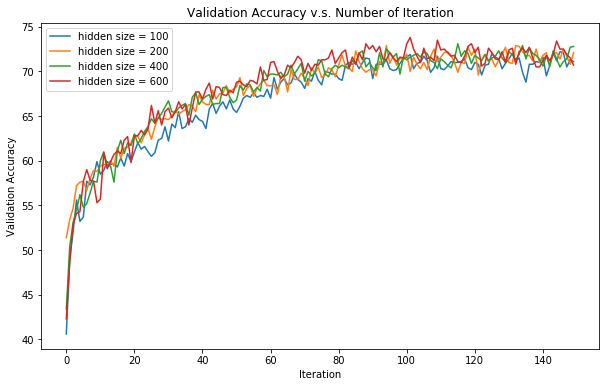

In [73]:
# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_h100, label="hidden size = 100")
plt.plot(val_acc_h200, label="hidden size = 200")
plt.plot(val_acc_h400, label="hidden size = 400")
plt.plot(val_acc_h600, label="hidden size = 600")
plt.legend(loc="best")
plt.savefig("GRN_hidden.png")
plt.show()

In [74]:
loss_h100 = pd.read_csv("./GRN/loss_h100_d0.csv")['training loss']
loss_h200 = pd.read_csv("./GRN/loss_h200_d0.csv")['training loss']
loss_h400 = pd.read_csv("./GRN/loss_h400_d0.csv")['training loss']
loss_h600 = pd.read_csv("./GRN/loss_h600_d0.csv")['training loss']

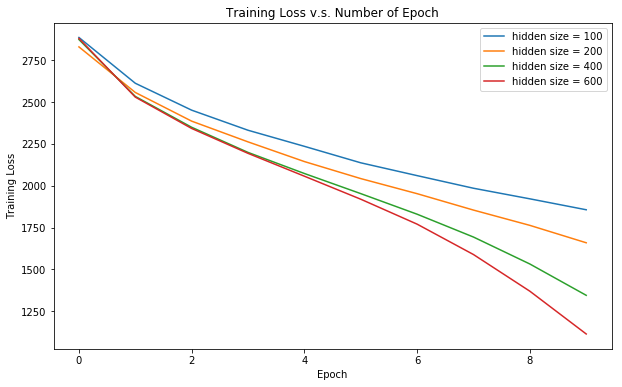

In [75]:
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(loss_h100, label="hidden size = 100")
plt.plot(loss_h200, label="hidden size = 200")
plt.plot(loss_h400, label="hidden size = 400")
plt.plot(loss_h600, label="hidden size = 600")
plt.legend(loc="best")
plt.savefig("GRN_hidden_loss.png")
plt.show()

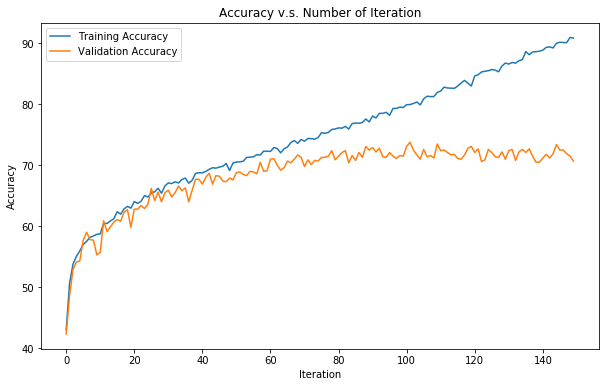

In [76]:
# plot
train_acc_h600 = pd.read_csv("./GRN/acc_h600_d0.csv")['training accuracy']
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title("Accuracy v.s. Number of Iteration")
plt.plot(train_acc_h600, label="Training Accuracy")
plt.plot(val_acc_h600, label="Validation Accuracy")
plt.legend(loc="best")
plt.savefig("dropout_tvacc.png")
plt.show()

# 2. Drop Out

In [3]:
val_acc_d0 = pd.read_csv("./GRN/acc_h600_d0.csv")['validation accuracy']
val_acc_d3 = pd.read_csv("./GRN/acc_h600_d3.csv")['validation accuracy']
val_acc_d5 = pd.read_csv("./GRN/acc_h600_d5.csv")['validation accuracy']

In [8]:
max(val_acc_d5)

73.1

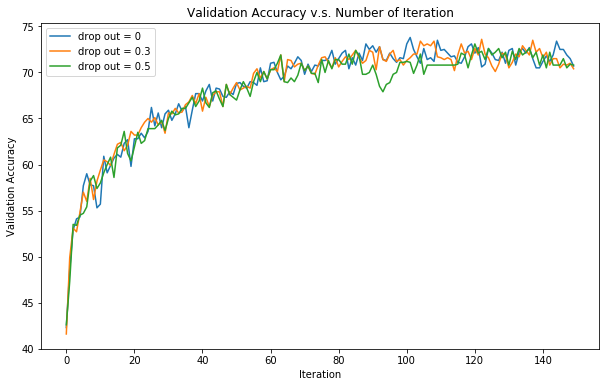

In [7]:
# plot

fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_d0, label="drop out = 0")
plt.plot(val_acc_d3, label="drop out = 0.3")
plt.plot(val_acc_d5, label="drop out = 0.5")
plt.legend(loc="best")
plt.savefig("GRN_dropout.png")
plt.show()

In [9]:
loss_d0 = pd.read_csv("./GRN/loss_h600_d0.csv")['training loss']
loss_d3 = pd.read_csv("./GRN/loss_h600_d3.csv")['training loss']
loss_d5 = pd.read_csv("./GRN/loss_h600_d5.csv")['training loss']

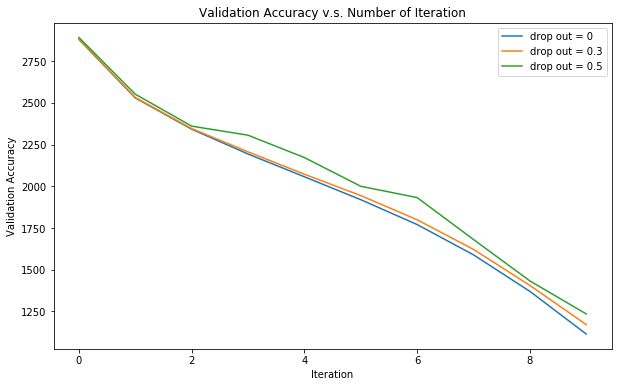

In [10]:
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(loss_d0, label="drop out = 0")
plt.plot(loss_d3, label="drop out = 0.3")
plt.plot(loss_d5, label="drop out = 0.5")
plt.legend(loc="best")
plt.savefig("GRN_dropout_loss.png")
plt.show()

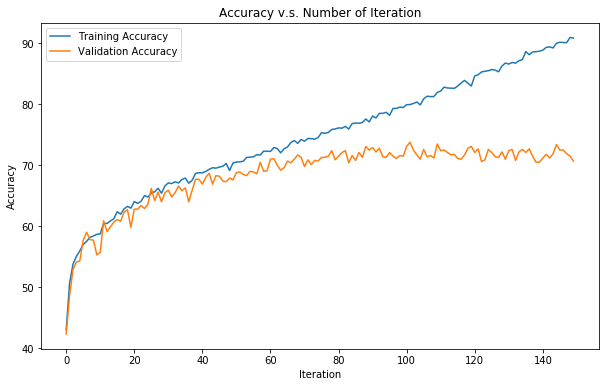

In [13]:
# plot
train_acc_h600 = pd.read_csv("./GRN/acc_h600_d0.csv")['training accuracy']
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title("Accuracy v.s. Number of Iteration")
plt.plot(train_acc_h600, label="Training Accuracy")
plt.plot(val_acc_h600, label="Validation Accuracy")
plt.legend(loc="best")
plt.savefig("dropout_tvacc.png")
plt.show()

# Performance on Test set (MultiSLI)

In [63]:
test_dict = {}
test_dict["genre"] = genre_lst
test_dict["test acc"] = []
for genre in genre_lst:
    test_dict["test acc"].append(test_model(test_loader_dict[genre], model))
test_df = pd.DataFrame(test_dict)
test_df

,genre,test acc
0,fiction,49.246231
1,telephone,46.666667
2,slate,46.007984
3,government,47.244094
4,travel,45.621181


# Prediction Samples

In [96]:
def correct_pred_finder(loader, model):
    """
    Function that return the index of correct prediction in the batch
    """
    model.eval()
    index_store = []
    prediction_store = []
    for data1, data2, lengths1, length2, labels in loader:
        outputs = F.softmax(model( data1, data2, lengths1, length2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1] 
        #print(predicted.cpu().numpy())
        prediction_store += [prediction[0] for prediction in predicted.cpu().numpy()]
        check_tensor = torch.eq(predicted.view_as(labels), labels)
        check_arr = check_tensor.cpu().numpy()
        index = np.argwhere(check_arr)
        index_store.append(index)
    return index_store, prediction_store

In [97]:
index_tmp, prediction = correct_pred_finder(val_loader, model)
index_lst = []
# index_lst stores all the index of correct prediction in validation set
for i in range(len(index_tmp)):
    index = [index[0]+batch_size*i for index in index_tmp[i]]
    index_lst += index

In [ ]:
from sklearn import preprocessing
>>> le = preprocessing.LabelEncoder()
>>> le.fit([1, 2, 2, 6])
LabelEncoder()
>>> le.classes_
array([1, 2, 6])
>>> le.transform([1, 1, 2, 6]) 
array([0, 0, 1, 2]...)
>>> le.inverse_transform([0, 0, 1, 2])
array([1, 1, 2, 6])

In [98]:
val_label = le.inverse_transform(val_label)
prediction = le.inverse_transform(prediction)

In [112]:
# e.g.
index_lst[:15]

[1, 2, 3, 4, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 21]

In [100]:
# e.g.
val_label[:10]

array(['contradiction', 'entailment', 'entailment', 'entailment',
       'entailment', 'entailment', 'entailment', 'contradiction',
       'neutral', 'contradiction'], dtype='<U13')

In [101]:
# e.g.
prediction[:10]

array(['entailment', 'entailment', 'entailment', 'entailment',
       'entailment', 'contradiction', 'entailment', 'entailment',
       'neutral', 'entailment'], dtype='<U13')

# Correct Prediction

In [49]:
val_sent1, val_sent2, val_label = dataset_builder("snli_val.tsv")

In [104]:
print("Premise:")
print(' '.join(val_sent1[1]))
print("\nHypothesis:")
print(' '.join(val_sent2[1]))
print("\nLabel:")
print(val_label[1])
print("\nPrediction:")
print(prediction[1])

Premise:
four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .

Hypothesis:
multiple people are on a subway together , with each of them doing their own thing .

Label:
entailment

Prediction:
entailment


In [105]:
print("Premise:")
print(' '.join(val_sent1[2]))
print("\nHypothesis:")
print(' '.join(val_sent2[2]))
print("\nLabel:")
print(val_label[2])
print("\nPrediction:")
print(prediction[2])

Premise:
bicycles stationed while a group of people socialize .

Hypothesis:
people get together near a stand of bicycles .

Label:
entailment

Prediction:
entailment


In [113]:
print("Premise:")
print(' '.join(val_sent1[20]))
print("\nHypothesis:")
print(' '.join(val_sent2[20]))
print("\nLabel:")
print(val_label[20])
print("\nPrediction:")
print(prediction[20])

Premise:
a woman is sitting in a street market stand where there are various items for sale , such as fish .

Hypothesis:
the woman is in a street market .

Label:
entailment

Prediction:
contradiction


# Wrong Prediction

In [111]:
print("Premise:")
print(' '.join(val_sent1[13]))
print("\nHypothesis:")
print(' '.join(val_sent2[13]))
print("\nLabel:")
print(val_label[13])
print("\nPrediction:")
print(prediction[13])

Premise:
man in white shirt and blue jeans looking to the side while walking down a busy sidewalk .

Hypothesis:
man has a blue shirt on .

Label:
contradiction

Prediction:
entailment


In [108]:
print("Premise:")
print(' '.join(val_sent1[5]))
print("\nHypothesis:")
print(' '.join(val_sent2[5]))
print("\nLabel:")
print(val_label[5])
print("\nPrediction:")
print(prediction[5])

Premise:
two people are in a green forest .

Hypothesis:
the forest is not dead .

Label:
entailment

Prediction:
contradiction


In [110]:
print("Premise:")
print(' '.join(val_sent1[9]))
print("\nHypothesis:")
print(' '.join(val_sent2[9]))
print("\nLabel:")
print(val_label[9])
print("\nPrediction:")
print(prediction[9])

Premise:
three people and a white dog are sitting in the sand on a beach .

Hypothesis:
three dogs and a person are sitting in the snow .

Label:
contradiction

Prediction:
entailment


### End of HW2 GRN